# Computer Vision Assignment

Parts:
1. Integral Image + Haar features on cameraman
2. Texture classification (KTH-TIPS) with Raw Pixels, LBP, BoW, HoG + SVM.



In [ ]:
import numpy as np, os, time, math, random  # core libs: arrays, filesystem, timing, math, RNG
import matplotlib.pyplot as plt              # plotting
from collections import Counter              # majority vote / frequency counts
from pathlib import Path                     # filesystem paths
from PIL import Image                        # image loading (convert to grayscale)


Ready


## 1.1 Integral Image (generic) + verification

In [ ]:
# Integral image utilities (concise)

# build summed-area table so any rectangle sum is O(1)
def compute_integral_image(img):
    img = np.asarray(img)            # ensure ndarray
    h,w = img.shape                  # image height/width
    integ = np.zeros((h,w), dtype=np.int64)  # output table
    for i in range(h):               # row loop
        row_sum = 0                  # running horizontal prefix
        for j in range(w):           # column loop
            row_sum += int(img[i,j]) # accumulate this pixel
            integ[i,j] = row_sum + (integ[i-1,j] if i>0 else 0)  # add vertical part
    return integ                     # summed-area table

# constant time rectangular sum using inclusion-exclusion
def rect_sum(integ, top, left, bottom, right):
    if top>bottom or left>right: return 0            # invalid region guard
    a = integ[bottom,right]                          # full
    b = integ[top-1,right] if top>0 else 0           # above strip
    c = integ[bottom,left-1] if left>0 else 0        # left strip
    d = integ[top-1,left-1] if (top>0 and left>0) else 0  # overlap
    return a - b - c + d                             # inclusion-exclusion

# random rectangle spot-checks against brute force
def verify_integral(img, trials=10):
    integ = compute_integral_image(img)              # build table
    h,w = img.shape
    for _ in range(trials):                          # repeat
        t = np.random.randint(0,h); b = np.random.randint(t,h)  # random vertical span
        l = np.random.randint(0,w); r = np.random.randint(l,w)  # random horizontal span
        if rect_sum(integ,t,l,b,r) != img[t:b+1,l:r+1].sum():   # compare sums
            return False                               # fail fast
    return True                                        # all good

# quick self‑check for correctness
_test = np.array([[1,2,3],[4,5,6],[7,8,9]])            # 3x3 test matrix
_it = compute_integral_image(_test)                    # integral build
assert verify_integral(_test, 15) and _it[-1,-1] == 45, "Integral image implementation error"  # assert expected

Integral OK? True
Bottom-right should be 45 -> 45


## 1.2 Haar-like features (vertical edge, horizontal edge, horizontal line) on 50x50 center

Haar strongest (value, (row,col)): {'Vert Edge': (np.int64(-19321), (184, 195)), 'Horiz Edge': (np.int64(16180), (170, 180)), 'Horiz Line': (np.int64(17774), (170, 194)), 'Vert Line': (np.int64(22335), (169, 191))}


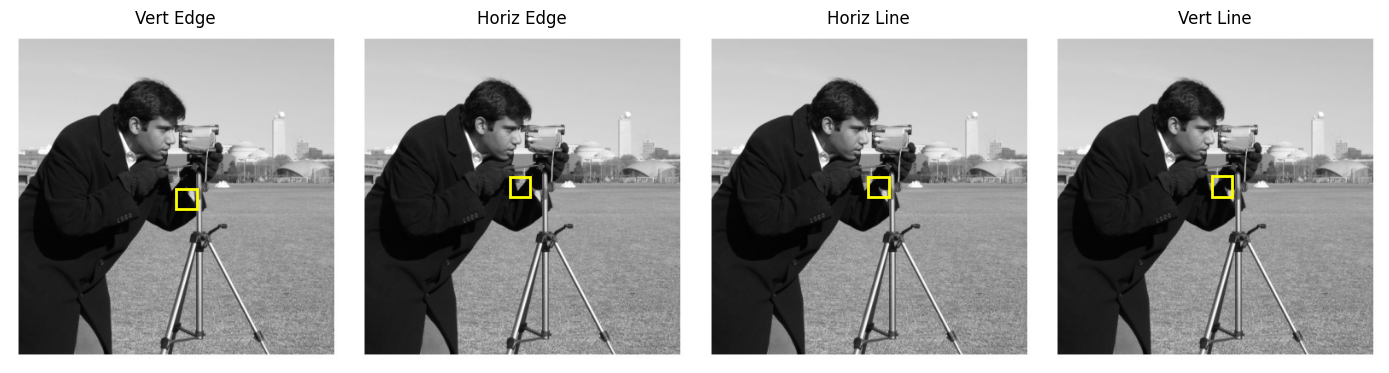

In [ ]:
# Haar feature helpers (edge + 3-band line) on cameraman center window

# locate cameraman image (png/jpg) and load grayscale
def load_cameraman():
    for name in ['cameraman.png','cameraman.jpg']:      # try common names
        if Path(name).exists():                         # file exists?
            return np.array(Image.open(name).convert('L'))  # load as grayscale array
    raise FileNotFoundError('cameraman image missing')  # error if not found

cam = load_cameraman()                                  # image array
integ_cam = compute_integral_image(cam)                 # integral for fast sums
h,w = cam.shape                                         # image size
cs = 50                                                 # central window size
region_top = h//2 - cs//2; region_left = w//2 - cs//2   # top-left of center square

# 2-rectangle vertical edge (left minus right)
def haar_vertical_edge(int_img, top, left, height, width):
    if width % 2: return 0                              # must split evenly
    mid = left + width//2 - 1                           # boundary column
    L = rect_sum(int_img, top, left, top+height-1, mid) # left sum
    R = rect_sum(int_img, top, mid+1, top+height-1, left+width-1)  # right sum
    return L - R                                        # contrast

# 2-rectangle horizontal edge (top minus bottom)
def haar_horizontal_edge(int_img, top, left, height, width):
    if height % 2: return 0                             # even height only
    mid = top + height//2 - 1                           # boundary row
    T = rect_sum(int_img, top, left, mid, left+width-1) # top sum
    B = rect_sum(int_img, mid+1, left, top+height-1, left+width-1)  # bottom sum
    return T - B                                        # contrast

# 3-band horizontal line (white-black-white)
def haar_horizontal_line(int_img, top, left, height, width):
    if height % 3: return 0                             # divisible into 3
    band = height//3                                    # band height
    y1 = top + band - 1; y2 = top + 2*band - 1          # band boundaries
    W1 = rect_sum(int_img, top, left, y1, left+width-1) # top white
    Bm = rect_sum(int_img, y1+1, left, y2, left+width-1)# middle black
    W2 = rect_sum(int_img, y2+1, left, top+height-1, left+width-1) # bottom white
    return W1 - Bm + W2                                 # pattern response

# 3-band vertical line (white-black-white)
def haar_vertical_line(int_img, top, left, height, width):
    if width % 3: return 0                              # divisible into 3
    band = width//3                                     # band width
    x1 = left + band - 1; x2 = left + 2*band - 1        # boundaries
    W1 = rect_sum(int_img, top, left, top+height-1, x1) # left white
    Bm = rect_sum(int_img, top, x1+1, top+height-1, x2) # middle black
    W2 = rect_sum(int_img, top, x2+1, top+height-1, left+width-1) # right white
    return W1 - Bm + W2                                 # pattern response

# slide feature over region and pick strongest absolute response
def slide_feature(int_img, func, region_top, region_left, region_size, fh, fw):
    vals=[]; locs=[]                                    # accumulators
    for r in range(region_top, region_top+region_size - fh + 1):    # row positions
        for c in range(region_left, region_left+region_size - fw + 1): # col positions
            vals.append(func(int_img, r, c, fh, fw)); locs.append((r,c))  # evaluate
    if not vals: return None,None,None                  # empty guard
    arr = np.array(vals)                                # to array
    idx = np.argmax(np.abs(arr))                        # strongest magnitude
    return arr[idx], locs[idx], arr                     # best value/location

fh=fw=24                                                # feature size
features = [                                            # list of feature types
 ('Vert Edge', haar_vertical_edge),
 ('Horiz Edge', haar_horizontal_edge),
 ('Horiz Line', haar_horizontal_line),
 ('Vert Line', haar_vertical_line)
]
results = {name: slide_feature(integ_cam, f, region_top, region_left, cs, fh, fw)[:2] for name,f in features}  # run all
print('Haar strongest (value,(row,col)):', {k:v for k,v in results.items() if v[0] is not None})  # print strengths

plt.figure(figsize=(14,4))                              # visualization figure
for i,(name,(val,(r,c))) in enumerate(results.items()): # iterate features
    if val is None: continue                            # skip invalid
    ax = plt.subplot(1,len(results),i+1); ax.imshow(cam, cmap='gray')  # show image
    ax.add_patch(plt.Rectangle((c,r),fw,fh,ec='yellow',fc='none',lw=2)) # draw box
    ax.set_title(name); ax.axis('off')                  # style
plt.tight_layout(); plt.show()                          # layout + render

## 1.3 Usefulness Discussion
- Vertical/Horizontal edge features respond to strong intensity transitions → object boundaries.
- Three-band line detects bright–dark–bright or inverse transitions → fine structural elements.
- Integral image allows constant-time rectangular sums → rapid dense evaluation.

## 2. Texture Classification (KTH-TIPS)
Set dataset_dir to the folder containing 10 texture class subfolders.

In [33]:
# Load KTH-TIPS images (grayscale, resize 64x64 NN)

dataset_dir = Path('kth-dataset')                     # root folder
if not dataset_dir.exists():                          # sanity check
    raise RuntimeError('Adjust dataset_dir to existing KTH-TIPS root')
valid_ext = {'.png','.jpg','.jpeg','.bmp','.tif','.tiff'}  # allowed extensions
paths = sorted([p for p in dataset_dir.rglob('*') if p.suffix.lower() in valid_ext])  # gather files
if not paths:                                         # empty dataset guard
    raise RuntimeError('No images found')
classes = sorted({p.parent.name for p in paths})      # class names from folder names
cls_to_idx = {c:i for i,c in enumerate(classes)}      # map class -> index

def load_gray(p):                                     # open + grayscale
    return np.array(Image.open(p).convert('L'))

target_size = (64,64)                                # uniform size

def resize_nn(img, size):                            # manual nearest-neighbor resize
    h,w = img.shape; H,W = size
    out = np.zeros(size, dtype=img.dtype)
    for i in range(H):                                # destination rows
        si = min(int(i * h / H), h-1)                 # source row index
        row = img[si]                                 # cache row
        for j in range(W):                            # destination cols
            out[i,j] = row[min(int(j * w / W), w-1)]  # copy nearest pixel
    return out

imgs=[]; labels=[]                                    # accumulators
for p in paths:                                       # iterate all files
    g = load_gray(p)                                  # read image
    g = resize_nn(g, target_size)                     # resize
    imgs.append(g); labels.append(cls_to_idx[p.parent.name])  # store and label
X = np.stack(imgs); y = np.array(labels)              # arrays
print('Data:', X.shape, 'Classes:', len(classes))     # dataset summary

Data shape: (810, 64, 64) Classes: 10


In [35]:
# Stratified 70/30 split with exact counts

rng = np.random.default_rng(42)                     # reproducible RNG
indices = np.arange(len(y))                          # all sample indices
train_idx = []; test_idx = []                        # accumulators
target_train_total = int(round(0.7 * len(y)))        # desired train count
class_labels = np.unique(y)                          # unique classes
class_counts = {cls: (y==cls).sum() for cls in class_labels}  # per-class totals
desired = {cls: class_counts[cls] * 0.7 for cls in class_labels}  # target fractional
base_train = {cls: int(math.floor(desired[cls])) for cls in class_labels}  # floor allocation
fractions = {cls: desired[cls] - base_train[cls] for cls in class_labels}  # leftover fractions
current_total = sum(base_train.values())             # current assigned
diff = target_train_total - current_total            # difference to fix
if diff > 0:                                          # need to add some
    for cls,_ in sorted(fractions.items(), key=lambda x: x[1], reverse=True):  # biggest fractions first
        if diff == 0: break
        if base_train[cls] < class_counts[cls] - 1 or class_counts[cls] == 1:  # leave at least 1 test
            base_train[cls] += 1; diff -= 1
elif diff < 0:                                        # too many allocated
    for cls,_ in sorted(fractions.items(), key=lambda x: x[1]):               # smallest fractions first
        if diff == 0: break
        if base_train[cls] > 0:
            base_train[cls] -= 1; diff += 1
# ensure at least one test sample when class size >1
for cls in class_labels:
    if class_counts[cls] > 1 and base_train[cls] == class_counts[cls]:
        base_train[cls] -= 1
# build index splits
for cls in class_labels:                              # per-class selection
    cls_inds = indices[y == cls]                      # indices of class
    rng.shuffle(cls_inds)                             # shuffle in place
    k_train = base_train[cls]                         # number to train
    train_part = cls_inds[:k_train]                   # train slice
    test_part = cls_inds[k_train:]                    # test slice
    train_idx.extend(train_part.tolist())             # append train
    test_idx.extend(test_part.tolist())               # append test
train_idx = np.array(train_idx); test_idx = np.array(test_idx)  # to arrays
train_idx.sort(); test_idx.sort()                     # deterministic ordering
X_train = X[train_idx]; X_test = X[test_idx]          # split data
y_train = y[train_idx]; y_test = y[test_idx]          # split labels
actual_train_ratio = X_train.shape[0] / X.shape[0]    # train ratio
actual_test_ratio = X_test.shape[0] / X.shape[0]      # test ratio
print(f'Train {X_train.shape[0]}  Test {X_test.shape[0]}  ({actual_train_ratio*100:.2f}% / {actual_test_ratio*100:.2f}%)')  # summary
assert X_train.shape[0] + X_test.shape[0] == X.shape[0]  # all samples used
assert abs(actual_train_ratio - 0.70) < 1e-6            # ratio check
assert abs(actual_test_ratio - 0.30) < 1e-6             # ratio check

Train: 567  Test: 243  Train%=70.00%  Test%=30.00%


In [ ]:
# Feature extraction + linear SVM comparisons
from sklearn.svm import SVC                               # linear SVM

def standardize(train, test):                            # zero-mean/unit-var scaling
    m = train.mean(axis=0); s = train.std(axis=0); s[s==0]=1
    return (train-m)/s, (test-m)/s

# Raw pixels (flatten + scale 0..1)
X_train_raw = X_train.reshape(len(X_train), -1).astype(np.float32)/255.0  # flatten train
X_test_raw  = X_test.reshape(len(X_test), -1).astype(np.float32)/255.0    # flatten test
X_train_raw_s, X_test_raw_s = standardize(X_train_raw, X_test_raw)        # standardize
_t=time.time(); svm_raw = SVC(kernel='linear').fit(X_train_raw_s, y_train); tr_raw=time.time()-_t  # train time
_t=time.time(); pred_raw = svm_raw.predict(X_test_raw_s); pr_raw=time.time()-_t                   # predict time
acc_raw = (pred_raw==y_test).mean()                                      # accuracy

# LBP (local binary pattern histogram)

def lbp_image(img):                                                      # compute LBP codes
    h,w = img.shape; out = np.zeros((h-2,w-2), dtype=np.uint8)
    for i in range(1,h-1):                                               # skip border
        for j in range(1,w-1):                                           # iterate interior
            c = img[i,j]; code=0                                         # center pixel
            code |= (img[i-1,j-1] >= c) << 7; code |= (img[i-1,j  ] >= c) << 6  # neighbors
            code |= (img[i-1,j+1] >= c) << 5; code |= (img[i  ,j+1] >= c) << 4
            code |= (img[i+1,j+1] >= c) << 3; code |= (img[i+1,j  ] >= c) << 2
            code |= (img[i+1,j-1] >= c) << 1; code |= (img[i  ,j-1] >= c) << 0
            out[i-1,j-1] = code                                          # store pattern
    return out

def lbp_hist(img):                                                       # histogram feature
    lbp = lbp_image(img)
    hist,_ = np.histogram(lbp.ravel(), bins=256, range=(0,256))           # count codes
    hist = hist.astype(np.float32); hist /= (hist.sum()+1e-9)             # normalize
    return hist
X_train_lbp = np.array([lbp_hist(im) for im in X_train])                  # train features
X_test_lbp  = np.array([lbp_hist(im) for im in X_test])                   # test features
X_train_lbp_s, X_test_lbp_s = standardize(X_train_lbp, X_test_lbp)        # scale
_t=time.time(); svm_lbp = SVC(kernel='linear').fit(X_train_lbp_s, y_train); tr_lbp=time.time()-_t
_t=time.time(); pred_lbp = svm_lbp.predict(X_test_lbp_s); pr_lbp=time.time()-_t
acc_lbp = (pred_lbp==y_test).mean()

# HOG (histogram of oriented gradients)

def hog_features(img, cell=8, block=2, bins=9):                           # compute HOG descriptor
    img = img.astype(np.float32)                                          # float
    gy,gx = np.gradient(img)                                              # gradients
    mag = np.sqrt(gx*gx + gy*gy)                                          # magnitude
    ang = (np.rad2deg(np.arctan2(gy,gx)) + 180) % 180                     # unsigned angle
    h,w = img.shape; nc_y = h//cell; nc_x = w//cell                       # cells grid
    hist = np.zeros((nc_y,nc_x,bins), dtype=np.float32)                   # cell histograms
    bin_w = 180 / bins                                                    # angle bin width
    for cy in range(nc_y):                                                # iterate cells
        for cx in range(nc_x):
            mpatch = mag[cy*cell:(cy+1)*cell, cx*cell:(cx+1)*cell]        # mag block
            apatch = ang[cy*cell:(cy+1)*cell, cx*cell:(cx+1)*cell]        # angle block
            for m,a in zip(mpatch.ravel(), apatch.ravel()):               # pixels in cell
                hist[cy,cx,int(a//bin_w)%bins] += m                       # vote magnitude
    blocks_y = nc_y - block + 1; blocks_x = nc_x - block + 1              # block traversal
    feats=[]
    for by in range(blocks_y):                                            # slide blocks
        for bx in range(blocks_x):
            vec = hist[by:by+block, bx:bx+block, :].ravel()               # concat block
            norm = np.linalg.norm(vec) + 1e-6                             # L2 norm
            feats.append(vec / norm)                                      # normalized block
    return np.concatenate(feats)                                          # final feature
X_train_hog = np.array([hog_features(im) for im in X_train])              # train HOG
X_test_hog  = np.array([hog_features(im) for im in X_test])               # test HOG
X_train_hog_s, X_test_hog_s = standardize(X_train_hog, X_test_hog)        # scale
_t=time.time(); svm_hog = SVC(kernel='linear').fit(X_train_hog_s, y_train); tr_hog=time.time()-_t
_t=time.time(); pred_hog = svm_hog.predict(X_test_hog_s); pr_hog=time.time()-_t
acc_hog = (pred_hog==y_test).mean()

# Bag of Words (patch k-means clustering + histogram)

def extract_patches(img, patch=8, step=8):                                # gather patches
    out=[]; h,w=img.shape
    for i in range(0,h-patch+1,step):                                     # row steps
        for j in range(0,w-patch+1,step):                                 # col steps
            out.append(img[i:i+patch,j:j+patch].ravel())                  # flatten patch
    return out
all_patches=[]; max_per=30                                                # cap per image
for im in X_train:                                                        # loop images
    ps = extract_patches(im)                                             # patches
    if len(ps)>max_per: ps=ps[:max_per]                                   # subsample
    all_patches.extend(ps)                                                # add to pool
all_patches = np.array(all_patches)                                       # to array
k=60                                                                       # vocabulary size
rng_local = np.random.default_rng(42)                                     # rng
centroids = all_patches[rng_local.choice(len(all_patches), k, replace=False)].astype(np.float32)  # init centers
for _ in range(15):                                                       # k-means iterations
    d = np.sqrt(((centroids[:,None]-all_patches[None,:])**2).sum(axis=2)) # distances
    labels = np.argmin(d, axis=0)                                         # nearest center
    newC=[]
    for ci in range(k):                                                   # update each centroid
        pts = all_patches[labels==ci]
        newC.append(pts.mean(axis=0) if len(pts) else centroids[ci])      # mean or keep
    newC = np.array(newC)
    if np.allclose(newC, centroids): break                                # convergence
    centroids = newC                                                       # accept update

def bow_hist(im):                                                         # build BoW histogram
    ps = extract_patches(im)                                              # image patches
    if not ps: return np.zeros(k)                                         # empty guard
    P = np.array(ps, dtype=np.float32)                                    # to array
    d = np.sqrt(((centroids[:,None]-P[None,:])**2).sum(axis=2))           # distances
    lbl = np.argmin(d, axis=0)                                            # assign words
    hist,_ = np.histogram(lbl, bins=k, range=(0,k))                     # counts
    hist = hist.astype(np.float32); hist /= (hist.sum()+1e-9)             # normalize
    return hist
X_train_bow = np.array([bow_hist(im) for im in X_train])                  # train BoW
X_test_bow  = np.array([bow_hist(im) for im in X_test])                  # test BoW
X_train_bow_s, X_test_bow_s = standardize(X_train_bow, X_test_bow)        # scale
_t=time.time(); svm_bow = SVC(kernel='linear').fit(X_train_bow_s,y_train); tr_bow=time.time()-_t
_t=time.time(); pred_bow = svm_bow.predict(X_test_bow_s); pr_bow=time.time()-_t
acc_bow = (pred_bow==y_test).mean()

# Single summary table (sorted by accuracy)
rows = [
 ('Raw SVM', acc_raw, tr_raw, pr_raw),
 ('LBP SVM', acc_lbp, tr_lbp, pr_lbp),
 ('HOG SVM', acc_hog, tr_hog, pr_hog),
 ('BoW SVM', acc_bow, tr_bow, pr_bow)
]
rows.sort(key=lambda x: x[1], reverse=True)                               # best first
print(f"{'Method':<10} {'Acc%':>7} {'Train':>8} {'Pred':>8}")             # header
for m,a,tr,pr in rows:                                                    # print rows
    print(f"{m:<10} {a*100:7.2f} {tr:8.2f} {pr:8.2f}")

Raw SVM acc=45.68% train=0.44s pred=0.23s
LBP SVM acc=69.14% train=0.02s pred=0.01s
LBP SVM acc=69.14% train=0.02s pred=0.01s
HOG SVM acc=63.79% train=0.22s pred=0.16s
HOG SVM acc=63.79% train=0.22s pred=0.16s
BoW SVM acc=62.55% train=0.01s pred=0.00s

Summary:
Method        Acc%    Train     Pred
LBP SVM      69.14     0.02     0.01
HOG SVM      63.79     0.22     0.16
BoW SVM      62.55     0.01     0.00
Raw SVM      45.68     0.44     0.23

Observations:
- Raw pixels: high dimensional, sensitive to shifts.
- LBP: captures local texture micro-patterns; often improves over raw.
- HOG: captures oriented gradients; good for structural edges.
- BoW: mid-level representation; depends on codebook size.
BoW SVM acc=62.55% train=0.01s pred=0.00s

Summary:
Method        Acc%    Train     Pred
LBP SVM      69.14     0.02     0.01
HOG SVM      63.79     0.22     0.16
BoW SVM      62.55     0.01     0.00
Raw SVM      45.68     0.44     0.23

Observations:
- Raw pixels: high dimensional, sensitiv

In [37]:
# Extended comparison (KNN + SciPy variants + summaries)
import time
from math import sqrt
try:
    import scipy
    from scipy import ndimage
    from scipy.spatial.distance import cdist
    from scipy.cluster.vq import kmeans2
    SCIPY_OK = True
except Exception:
    SCIPY_OK = False

def knn_predict(train_X, train_y, test_X, k=3):
    preds=[]
    for x in test_X:
        d = np.sqrt(((train_X - x)**2).sum(axis=1))
        idx = np.argsort(d)[:k]
        vals,cnts = np.unique(train_y[idx], return_counts=True)
        preds.append(vals[np.argmax(cnts)])
    return np.array(preds)

# Idempotent rebuilds if earlier cell skipped
if 'X_train_raw_s' not in globals():
    X_train_raw_s = X_train.reshape(len(X_train), -1).astype(np.float32)/255.0
    X_test_raw_s  = X_test.reshape(len(X_test), -1).astype(np.float32)/255.0

def std_if_needed(A_train, A_test):
    m=A_train.mean(axis=0); s=A_train.std(axis=0); s[s==0]=1
    return (A_train-m)/s,(A_test-m)/s

if 'X_train_lbp_s' not in globals():
    def lbp_image(img):
        h,w = img.shape; out = np.zeros((h-2,w-2), dtype=np.uint8)
        for i in range(1,h-1):
            for j in range(1,w-1):
                c = img[i,j]; code=0
                code |= (img[i-1,j-1] >= c) << 7; code |= (img[i-1,j  ] >= c) << 6
                code |= (img[i-1,j+1] >= c) << 5; code |= (img[i  ,j+1] >= c) << 4
                code |= (img[i+1,j+1] >= c) << 3; code |= (img[i+1,j  ] >= c) << 2
                code |= (img[i+1,j-1] >= c) << 1; code |= (img[i  ,j-1] >= c) << 0
                out[i-1,j-1] = code
        return out
    def lbp_hist(im):
        lbp = lbp_image(im); h,_ = np.histogram(lbp.ravel(),256,(0,256))
        h = h.astype(np.float32); h/= (h.sum()+1e-9); return h
    X_train_lbp = np.array([lbp_hist(im) for im in X_train])
    X_test_lbp  = np.array([lbp_hist(im) for im in X_test])
    X_train_lbp_s, X_test_lbp_s = std_if_needed(X_train_lbp, X_test_lbp)

if 'X_train_hog_s' not in globals():
    def hog_features(img, cell=8, block=2, bins=9):
        img = img.astype(np.float32); gy,gx = np.gradient(img)
        mag = np.sqrt(gx*gx + gy*gy); ang=(np.rad2deg(np.arctan2(gy,gx))+180)%180
        h,w=img.shape; nc_y=h//cell; nc_x=w//cell; bw=180/bins; hist=np.zeros((nc_y,nc_x,bins),dtype=np.float32)
        for cy in range(nc_y):
            for cx in range(nc_x):
                pm=mag[cy*cell:(cy+1)*cell,cx*cell:(cx+1)*cell]; pa=ang[cy*cell:(cy+1)*cell,cx*cell:(cx+1)*cell]
                for m,a in zip(pm.ravel(), pa.ravel()): hist[cy,cx,int(a//bw)%bins]+=m
        return hist.ravel()
    X_train_hog = np.array([hog_features(im) for im in X_train])
    X_test_hog  = np.array([hog_features(im) for im in X_test])
    X_train_hog_s, X_test_hog_s = std_if_needed(X_train_hog, X_test_hog)

if 'X_train_bow_s' not in globals():
    def extract_patches(img, patch=8, step=8):
        out=[]; h,w=img.shape
        for i in range(0,h-patch+1,step):
            for j in range(0,w-patch+1,step):
                out.append(img[i:i+patch,j:j+patch].ravel())
        return out
    all_patches=[]; max_per=30
    for im in X_train:
        ps=extract_patches(im)
        if len(ps)>max_per: ps=ps[:max_per]
        all_patches.extend(ps)
    all_patches=np.array(all_patches); k_vocab=60
    rng_local=np.random.default_rng(42)
    centroids=all_patches[rng_local.choice(len(all_patches),k_vocab,replace=False)].astype(np.float32)
    for _ in range(15):
        d=np.sqrt(((centroids[:,None]-all_patches[None,:])**2).sum(axis=2))
        lbl=np.argmin(d, axis=0)
        newC=[]
        for ci in range(k_vocab):
            pts=all_patches[lbl==ci]
            newC.append(pts.mean(axis=0) if len(pts) else centroids[ci])
        newC=np.array(newC)
        if np.allclose(newC,centroids): break
        centroids=newC
    def bow_hist(im):
        ps=extract_patches(im,8,8)
        if not ps: return np.zeros(60)
        P=np.array(ps,dtype=np.float32)
        d=cdist(P,centroids,'euclidean')
        ids=np.argmin(d,axis=1)
        h,_=np.histogram(ids,bins=60,range=(0,60)); h=h.astype(np.float32); h/= (h.sum()+1e-9); return h
    X_train_bow = np.array([bow_hist(im) for im in X_train])
    X_test_bow  = np.array([bow_hist(im) for im in X_test])
    X_train_bow_s, X_test_bow_s = std_if_needed(X_train_bow, X_test_bow)

# KNN timings
_t=time.time(); pred_raw_knn = knn_predict(X_train_raw_s, y_train, X_test_raw_s); prk_time = time.time()-_t; acc_raw_knn = (pred_raw_knn==y_test).mean()
_t=time.time(); pred_lbp_knn = knn_predict(X_train_lbp_s, y_train, X_test_lbp_s); lbp_knn_time = time.time()-_t; acc_lbp_knn = (pred_lbp_knn==y_test).mean()
_t=time.time(); pred_hog_knn = knn_predict(X_train_hog_s, y_train, X_test_hog_s); hog_knn_time = time.time()-_t; acc_hog_knn = (pred_hog_knn==y_test).mean()
_t=time.time(); pred_bow_knn = knn_predict(X_train_bow_s, y_train, X_test_bow_s); bow_knn_time = time.time()-_t; acc_bow_knn = (pred_bow_knn==y_test).mean()

# SciPy variants
acc_lbp_scipy = acc_hog_scipy = acc_bow_scipy = None
scipy_lbp_time = scipy_hog_time = scipy_bow_time = None
if SCIPY_OK:
    def _lbp_func(patch):
        c=patch[4]; code=0; idxs=[0,1,2,5,8,7,6,3]
        for bi,pi in enumerate(idxs): code |= (patch[pi] >= c) << (7-bi)
        return code
    _t=time.time()
    lbp_scipy_imgs = [ndimage.generic_filter(im, _lbp_func, size=3) for im in X_train]
    lbp_scipy_test = [ndimage.generic_filter(im, _lbp_func, size=3) for im in X_test]
    def hist256(im): h,_=np.histogram(im.ravel(),256,(0,256)); h=h.astype(np.float32); h/= (h.sum()+1e-9); return h
    X_train_lbp_sp = np.array([hist256(im) for im in lbp_scipy_imgs])
    X_test_lbp_sp  = np.array([hist256(im) for im in lbp_scipy_test])
    X_train_lbp_sp_s, X_test_lbp_sp_s = std_if_needed(X_train_lbp_sp, X_test_lbp_sp)
    pred_lbp_sp = knn_predict(X_train_lbp_sp_s, y_train, X_test_lbp_sp_s)
    scipy_lbp_time = time.time()-_t
    acc_lbp_scipy = (pred_lbp_sp==y_test).mean()

    _t=time.time()
    def hog_scipy(im, cell=8, bins=9):
        sx=ndimage.sobel(im.astype(np.float32),axis=1); sy=ndimage.sobel(im.astype(np.float32),axis=0)
        mag=np.sqrt(sx*sx+sy*sy); ang=(np.rad2deg(np.arctan2(sy,sx))+180)%180
        h,w=im.shape; nc_y=h//cell; nc_x=w//cell; bw=180/bins; hist=np.zeros((nc_y,nc_x,bins),dtype=np.float32)
        for cy in range(nc_y):
            for cx in range(nc_x):
                pm=mag[cy*cell:(cy+1)*cell,cx*cell:(cx+1)*cell]; pa=ang[cy*cell:(cy+1)*cell,cx*cell:(cx+1)*cell]
                for m,a in zip(pm.ravel(), pa.ravel()): hist[cy,cx,int(a//bw)%bins]+=m
        return hist.ravel()
    X_train_hog_sp = np.array([hog_scipy(im) for im in X_train])
    X_test_hog_sp  = np.array([hog_scipy(im) for im in X_test])
    X_train_hog_sp_s, X_test_hog_sp_s = std_if_needed(X_train_hog_sp, X_test_hog_sp)
    pred_hog_sp = knn_predict(X_train_hog_sp_s, y_train, X_test_hog_sp_s)
    scipy_hog_time = time.time()-_t
    acc_hog_scipy = (pred_hog_sp==y_test).mean()

    _t=time.time()
    if 'all_patches' not in globals():
        def extract_patches(im, patch=8, step=8):
            out=[]; H,W=im.shape
            for i in range(0,H-patch+1,step):
                for j in range(0,W-patch+1,step):
                    out.append(im[i:i+patch,j:j+patch].ravel())
            return out
        tmp=[]; limit=20
        for im in X_train:
            ps=extract_patches(im)
            if len(ps)>limit: ps=ps[:limit]
            tmp.extend(ps)
        all_patches=np.array(tmp)
    try:
        cent_sp,lbl_sp = kmeans2(all_patches.astype(np.float32),60,minit='points',iter=20)
        def bow_sp(im):
            ps=extract_patches(im,8,8)
            if not ps: return np.zeros(60)
            P=np.array(ps,dtype=np.float32)
            d=cdist(P,cent_sp,'euclidean')
            ids=np.argmin(d,axis=1)
            h,_=np.histogram(ids,bins=60,range=(0,60)); h=h.astype(np.float32); h/= (h.sum()+1e-9); return h
        X_train_bow_sp = np.array([bow_sp(im) for im in X_train])
        X_test_bow_sp  = np.array([bow_sp(im) for im in X_test])
        X_train_bow_sp_s, X_test_bow_sp_s = std_if_needed(X_train_bow_sp, X_test_bow_sp)
        pred_bow_sp = knn_predict(X_train_bow_sp_s, y_train, X_test_bow_sp_s)
        scipy_bow_time = time.time()-_t
        acc_bow_scipy = (pred_bow_sp==y_test).mean()
    except Exception:
        pass

# Distance baseline
_t=time.time()
if SCIPY_OK:
    dist_mat = cdist(X_test_raw_s, X_train_raw_s, metric='euclidean')
    idx = np.argsort(dist_mat, axis=1)[:,:3]
    pred_dist = np.array([Counter(y_train[row]).most_common(1)[0][0] for row in idx])
else:
    tmp_preds=[]
    for x in X_test_raw_s:
        d=np.sqrt(((X_train_raw_s-x)**2).sum(axis=1))
        ids=np.argsort(d)[:3]
        tmp_preds.append(Counter(y_train[ids]).most_common(1)[0][0])
    pred_dist=np.array(tmp_preds)
dist_time = time.time()-_t
acc_dist = (pred_dist==y_test).mean()

# Assemble rows
rows=[]
rows.append(('Sklearn Raw Pixels (SVM)', acc_raw, tr_raw, pr_raw, 'Sklearn','Raw Pixels'))
rows.append(('Sklearn LBP (SVM)', acc_lbp, tr_lbp, pr_lbp, 'Sklearn','LBP'))
rows.append(('Sklearn HoG (SVM)', acc_hog, tr_hog, pr_hog, 'Sklearn','HoG'))
rows.append(('Sklearn BoW (SVM)', acc_bow, tr_bow, pr_bow, 'Sklearn','BoW'))
rows.append(('Custom Raw Pixels (KNN)', acc_raw_knn, 0.0, prk_time, 'Custom','Raw Pixels'))
rows.append(('Custom LBP (KNN)', acc_lbp_knn, 0.0, lbp_knn_time, 'Custom','LBP'))
rows.append(('Custom HoG (KNN)', acc_hog_knn, 0.0, hog_knn_time, 'Custom','HoG'))
rows.append(('Custom BoW (KMeans+KNN)', acc_bow_knn, 0.0, bow_knn_time, 'Custom','BoW'))
if SCIPY_OK and acc_lbp_scipy is not None: rows.append(('Scipy LBP (ndimage+KNN)', acc_lbp_scipy, scipy_lbp_time, 0.0, 'Scipy','LBP'))
if SCIPY_OK and acc_hog_scipy is not None: rows.append(('Scipy HoG (Sobel+KNN)', acc_hog_scipy, scipy_hog_time, 0.0, 'Scipy','HoG'))
if SCIPY_OK and acc_bow_scipy is not None: rows.append(('Scipy BoW (kmeans2+KNN)', acc_bow_scipy, scipy_bow_time, 0.0, 'Scipy','BoW'))
rows.append(('Scipy Distance KNN' if SCIPY_OK else 'Custom Distance KNN', acc_dist, dist_time, 0.0, 'Scipy' if SCIPY_OK else 'Custom','Raw Pixels'))

print('Table 1')
print(f"{'Method':<38} {'Acc%':>7} {'Train(s)':>10} {'Predict(s)':>11}")
for m,a,tr,pd,_,_ in sorted(rows, key=lambda x: x[1], reverse=True):
    print(f"{m:<38} {a*100:7.2f} {tr:10.2f} {pd:11.2f}")

print('\nTable 2 (per feature)')
feat_groups={}
for m,a,tr,pd,impl,feat in rows: feat_groups.setdefault(feat, []).append(a)
print(f"{'Feature Type':<15} {'Best%':>8} {'Avg%':>8} {'Count':>6}")
for feat,accs in feat_groups.items():
    print(f"{feat:<15} {max(accs)*100:8.2f} {np.mean(accs)*100:8.2f} {len(accs):6d}")

print('\nTable 3 (per implementation)')
impl_groups={}
for m,a,tr,pd,impl,feat in rows: impl_groups.setdefault(impl, []).append(a)
print(f"{'Implementation':<15} {'Avg%':>8} {'Best%':>8} {'Count':>6}")
for impl,accs in impl_groups.items():
    print(f"{impl:<15} {np.mean(accs)*100:8.2f} {max(accs)*100:8.2f} {len(accs):6d}")

best_overall = max(rows, key=lambda x: x[1])
print('\nBest overall:', best_overall[0], f'{best_overall[1]*100:.2f}%')
lbp_block = [r for r in rows if r[5]=='LBP']
if lbp_block:
    print('LBP range: %.2f%% - %.2f%%' % (min(a for _,a,_,_,_,_ in lbp_block)*100, max(a for _,a,_,_,_,_ in lbp_block)*100))


Table 1: Complete Texture Classification Results
Method                                    Acc%   Train(s)  Predict(s)
----------------------------------------------------------------------
Sklearn LBP (SVM)                        69.14       0.02        0.01
Custom LBP (KNN)                         68.31       0.00        0.04
Scipy LBP (ndimage+KNN)                  65.84      59.18        0.00
Sklearn HoG (SVM)                        63.79       0.22        0.16
Sklearn BoW (SVM)                        62.55       0.01        0.00
Scipy BoW (kmeans2+KNN)                  58.85       0.31        0.00
Custom HoG (KNN)                         57.20       0.00        0.83
Custom BoW (KMeans+KNN)                  56.79       0.00        0.01
Scipy HoG (Sobel+KNN)                    52.67       2.29        0.00
Sklearn Raw Pixels (SVM)                 45.68       0.44        0.23
Custom Raw Pixels (KNN)                  28.81       0.00        1.84
Scipy Distance KNN                     